In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["KERAS_BACKEND"]="tensorflow"

In [3]:
import sys
sys.path.append('..')

In [4]:
import warnings
warnings.simplefilter("ignore")

In [5]:
import numpy as np

import keras
import keras.backend as K

Using TensorFlow backend.


In [6]:
K.set_image_data_format('channels_last')

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

# helper to simplify displaying multiple images
def imshow(image, width=64, height=64, size=None):
    
    im = np.array(image, copy=True)
    if image.min() < 0:
        im -= im.min()
    im /= im.max()
    im = (im*255.).astype(np.uint8)
    if np.ndim(im) == 3:
        im = np.expand_dims(im, 0)
 
    n = len(im)
    s = int(np.ceil(np.sqrt(n)))
    
    if size is None:
        size = 2*s
    
    fig, axs = plt.subplots(s, s)
    fig.set_size_inches(size,size)
    if s == 1:
        axs.imshow(im[0])
    else:
        cnt = 0
        for i in range(s):
            for j in range(s):
                if cnt < n:
                    axs[i,j].imshow(im[cnt, :,:,:])
                axs[i,j].axis('off')
                axs[i,j].set_aspect('equal')
                cnt += 1
        fig.subplots_adjust(wspace=0, hspace=0.)

    plt.show()

In [8]:
import tempfile

def replace_softmax_with_logits(model):
    model.layers[-1].activation = keras.activations.linear
    tmp_path = os.path.join(tempfile.gettempdir(), next(tempfile._get_candidate_names()) + '.h5')
    try:
        model.save(tmp_path)
        return keras.models.load_model(tmp_path)
    finally:
        os.remove(tmp_path)

# Target model: small Labeled Faces in the Wild (LFW)

In [9]:
from sklearn.datasets import fetch_olivetti_faces, fetch_lfw_people

# Use only classes that have at least 100 images
# There are five such classes in LFW
lfw_slice = (slice(68, 196, None), slice(61, 190, None))
faces_data = fetch_lfw_people(min_faces_per_person=100, color=True, slice_=lfw_slice)
images = faces_data.images
n_classes = faces_data.target.max()+1
x, y = faces_data.data, keras.utils.to_categorical(faces_data.target, n_classes)
images /= 255.0

# Use 3/4 for training, the rest for testing
N_tr = int(len(x)*0.75)
N_te = len(x) - N_tr
x_tr, y_tr = x[:N_tr], y[:N_tr]
x_te, y_te = x[N_tr:], y[N_tr:]
im_tr, im_te = images[:N_tr], images[N_tr:]

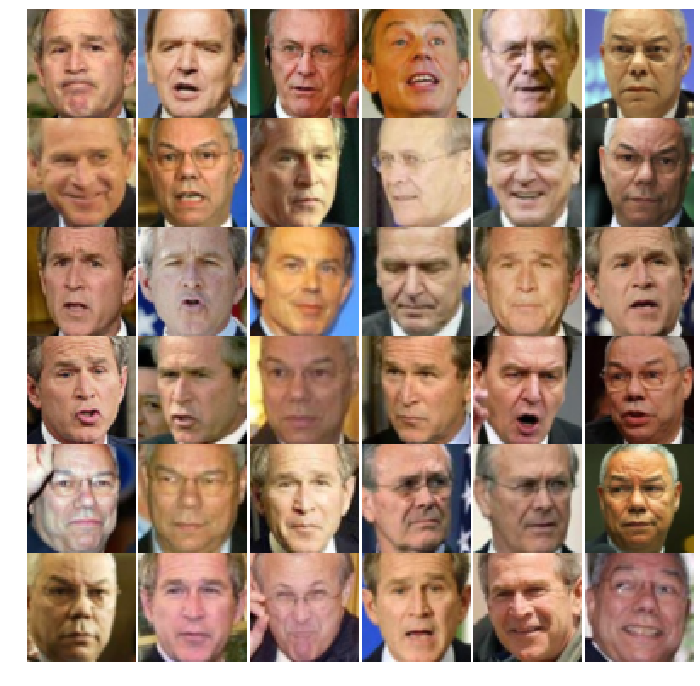

In [10]:
imshow(images[:36])

We'll use a small convnet to demonstrate, but with enough depth for interesting results

In [11]:
inp = keras.layers.Input(shape=im_tr[0].shape)
out = keras.layers.Conv2D(128, (3,3), activation='relu')(inp)
out = keras.layers.MaxPooling2D(pool_size=(2,2))(out)
out = keras.layers.Conv2D(64, (3,3), activation='relu')(out)
out = keras.layers.MaxPooling2D(pool_size=(2,2))(out)
out = keras.layers.Conv2D(32, (3,3), activation='relu')(out)
out = keras.layers.MaxPooling2D(pool_size=(2,2))(out)
out = keras.layers.Conv2D(16, (3,3), activation='relu')(out)
out = keras.layers.MaxPooling2D(pool_size=(2,2))(out)
out = keras.layers.Flatten()(out)
out = keras.layers.Dense(16, activation='relu')(out)
out = keras.layers.Dense(y[0].shape[0], activation='softmax')(out)
model = keras.Model(inp, out)
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 128)       3584      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
__________

The model was originally trained with:

`model.fit(im_tr, y_tr, batch_size=32, epochs=40, validation_data=(im_te, y_te))`

In [12]:
model.load_weights('weights/lfw-small-tf.h5')

In [13]:
print('accuracy:')
print('train={:.2}'.format(model.evaluate(im_tr, y_tr, verbose=False)[1]))
print('test={:.2}'.format(model.evaluate(im_te, y_te, verbose=False)[1]))

accuracy:
train=1.0
test=0.81


In [14]:
model = replace_softmax_with_logits(model)

# Finding invariants

Now let's find some invariants of the model. The main class for doing so is ``ActivationInvariants``.

In [15]:
%%time
from attribution.ActivationInvariants import ActivationInvariants

maxinv = ActivationInvariants(model, agg_fn=K.max).compile()

CPU times: user 2.28 s, sys: 4 ms, total: 2.28 s
Wall time: 2.27 s


In [16]:
%%time
maxinvs = maxinv.get_invariants(im_tr)

CPU times: user 908 ms, sys: 304 ms, total: 1.21 s
Wall time: 1.2 s


There are quite a few invariants that it found, but most of them have small support.

We define support as the percentage of samples with the relevant $Q$ value covered by the predicate. For example, using the default $Q$ which corresponds to the class label, the support is the percentage of the class that matches the invariant. This makes it possible to specify support without having to normalize for dataset size.

Let's look at a subset of them, and see the average support.

In [17]:
print('# invariants:', len(maxinvs), '\n')
for inv in maxinvs[:5]:
    print(inv, '\n')
supports = [inv.support for inv in maxinvs]
print('avg support: {:.2}'.format(np.array(supports).mean()))

# invariants: 257 

(dense_1[9] = 1 &
 dense_1[0] = 1 &
 flatten_1[32] = 1 &
 flatten_1[57] = 1 &
 flatten_1[37] = 1)
	--> Q = 4
support=0.0101, precision=1.0 

(dense_1[9] = 1 &
 dense_1[0] = 1 &
 flatten_1[32] = 1 &
 flatten_1[57] = 1 &
 flatten_1[37] = 0)
	--> Q = 1
support=0.0745, precision=1.0 

(dense_1[9] = 1 &
 dense_1[0] = 1 &
 flatten_1[32] = 1 &
 flatten_1[57] = 0 &
 max_pooling2d_1[107] = 1 &
 flatten_1[37] = 1 &
 conv2d_1[121] = 1)
	--> Q = 2
support=0.00252, precision=1.0 

(dense_1[9] = 1 &
 dense_1[0] = 1 &
 flatten_1[32] = 1 &
 flatten_1[57] = 0 &
 max_pooling2d_1[107] = 1 &
 flatten_1[37] = 1 &
 conv2d_1[121] = 0)
	--> Q = 1
support=0.0213, precision=1.0 

(dense_1[9] = 1 &
 dense_1[0] = 1 &
 flatten_1[32] = 1 &
 flatten_1[57] = 0 &
 max_pooling2d_1[107] = 1 &
 flatten_1[37] = 0)
	--> Q = 2
support=0.00504, precision=1.0 

avg support: 0.016


We can tell ``get_invariants`` to only return invariants with at least a minimum threshold of support. Likewise for precision.

In [18]:
%%time
maxinvs_highsup = maxinv.get_invariants(im_tr, min_support=0.5)
print(len(maxinvs_highsup))

0
CPU times: user 668 ms, sys: 164 ms, total: 832 ms
Wall time: 815 ms


### Flat aggregation of convolutional layers

It appears difficult to find high-support invariants for this model. This might be due to the fact that we use ``K.max`` to aggregate the convolutional layers, resulting in many fewer features for the decision tree learner to use.

In [19]:
%%time
flatinv = ActivationInvariants(model, agg_fn=None).compile()

CPU times: user 724 ms, sys: 12 ms, total: 736 ms
Wall time: 731 ms


Note that this will take significantly longer to find invariants, because there are now so many features

In [20]:
%%time
flatinvs = flatinv.get_invariants(im_tr, min_support=0.5)
print(len(flatinvs))

2
CPU times: user 42.7 s, sys: 4.14 s, total: 46.8 s
Wall time: 44.7 s


In [21]:
for inv in flatinvs[:5]:
    print(inv, '\n')
supports = [inv.support for inv in flatinvs]
print('avg support: {:.2}'.format(np.array(supports).mean()))

(dense_1[9] = 0 &
 dense_1[0] = 1 &
 conv2d_2[18784] = 1 &
 max_pooling2d_1[70912] = 1 &
 conv2d_1[459237] = 1)
	--> Q = 0
support=0.549, precision=1.0 

(dense_1[9] = 0 &
 dense_1[0] = 0 &
 max_pooling2d_1[7365] = 1 &
 conv2d_1[40408] = 1 &
 conv2d_2[3930] = 1 &
 conv2d_3[435] = 1 &
 conv2d_1[417063] = 1 &
 conv2d_1[275278] = 1 &
 conv2d_1[123314] = 0 &
 conv2d_1[1084] = 1)
	--> Q = 4
support=0.515, precision=1.0 

avg support: 0.53


In general, we would not expect flattened features in convolutional layers to generalize to new data.
Quite simply, they are location-specific, and so very sensitive to non-essential aspects of the image.

We can see this plainly on the second invariant by evaluating it on training and test data.
The ``Invariant`` class has a ``get_executable`` method that compiles the predicate for the backend given in ``K.backend()``.

In [22]:
%%time
flatinv1_f = flatinvs[1].get_executable()
flatinv1_tr_inds = np.where(flatinv1_f(im_tr))
flatinv1_te_inds = np.where(flatinv1_f(im_te))

CPU times: user 316 ms, sys: 16 ms, total: 332 ms
Wall time: 409 ms


The invariant has precision=1.0 on the training data, so we would expect the model to predict label 4 for all of the instances satisfying this predicate (those indices are in ``flatinv1_tr_inds``).

In [23]:
model.predict(im_tr[flatinv1_tr_inds]).argmax(axis=1)

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4])

The question is how many test instances satisfying the predicate are given label 4 by the model?
As we see below, this is not a great predicate.

In [24]:
model.predict(im_te[flatinv1_te_inds]).argmax(axis=1)

array([4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 0, 1, 2, 4])

Perhaps we can find a better set of high-support invariants by looking higher in the network.
``AttributionInvariant`` lets us pass in a list of layers to gather features from.
We'll try from ``max_pooling2d_2`` through ``dense_1``.

In [25]:
%%time
flatinv = ActivationInvariants(model, layers=list(range(4,11)), agg_fn=None).compile()

CPU times: user 612 ms, sys: 12 ms, total: 624 ms
Wall time: 619 ms


In [26]:
%%time
flatinvs = flatinv.get_invariants(im_tr, min_support=0.5)
print(len(flatinvs))

2
CPU times: user 1.06 s, sys: 192 ms, total: 1.25 s
Wall time: 1.25 s


In [27]:
for inv in flatinvs[:5]:
    print(inv, '\n')
supports = [inv.support for inv in flatinvs]
print('avg support: {:.2}'.format(np.array(supports).mean()))

(dense_1[9] = 0 &
 dense_1[0] = 1 &
 max_pooling2d_2[10308] = 1 &
 conv2d_3[3571] = 1 &
 max_pooling2d_2[12149] = 1 &
 max_pooling2d_3[560] = 1)
	--> Q = 0
support=0.527, precision=1.0 

(dense_1[9] = 0 &
 dense_1[0] = 0 &
 max_pooling2d_2[90] = 1 &
 conv2d_3[435] = 1 &
 conv2d_3[704] = 1 &
 conv2d_3[256] = 1 &
 conv2d_3[361] = 0 &
 max_pooling2d_2[3482] = 0 &
 conv2d_3[94] = 1 &
 max_pooling2d_2[5594] = 0 &
 conv2d_3[4014] = 0 &
 conv2d_3[307] = 1 &
 conv2d_3[2592] = 1 &
 max_pooling2d_2[6170] = 0)
	--> Q = 4
support=0.566, precision=1.0 

avg support: 0.55


In [28]:
%%time
flatinv0_f = flatinvs[0].get_executable()
flatinv0_te_inds = np.where(flatinv0_f(im_te))
flatinv0_te_acc = np.mean(model.predict(im_te[flatinv0_te_inds]).argmax(axis=1) == flatinvs[0].Q)
print('inv[0] test precision: {:.2}'.format(flatinv0_te_acc))
flatinv1_f = flatinvs[1].get_executable()
flatinv1_te_inds = np.where(flatinv1_f(im_te))
flatinv1_te_acc = np.mean(model.predict(im_te[flatinv1_te_inds]).argmax(axis=1) == flatinvs[1].Q)
print('inv[1] test precision: {:.2}'.format(flatinv1_te_acc))

inv[0] test precision: 0.83
inv[1] test precision: 0.58
CPU times: user 420 ms, sys: 8 ms, total: 428 ms
Wall time: 449 ms


Still not great.
Let's go back to aggregating with ``K.max``, but still use the same range of layers.
Finding the right set of layers can help with invariant quality, much in the same way that feature selection can help with model quality when using decision tree learning.

In [29]:
%%time
maxinv = ActivationInvariants(model, layers=list(range(4,11)), agg_fn=K.max).compile()
maxinvs = maxinv.get_invariants(im_tr, min_support=0.2)
for inv in maxinvs[:5]:
    print(inv, '\n')
supports = [inv.support for inv in maxinvs]
print('avg support: {:.2}\n'.format(np.array(supports).mean()))

(dense_1[9] = 1 &
 dense_1[0] = 0 &
 dense_1[7] = 0 &
 flatten_1[40] = 1 &
 flatten_1[39] = 1 &
 flatten_1[0] = 1 &
 flatten_1[56] = 1 &
 flatten_1[9] = 1)
	--> Q = 2
support=0.423, precision=1.0 

(dense_1[9] = 0 &
 dense_1[0] = 1 &
 dense_1[10] = 1 &
 dense_1[2] = 1 &
 flatten_1[57] = 0)
	--> Q = 0
support=0.245, precision=1.0 

avg support: 0.33

CPU times: user 1.63 s, sys: 116 ms, total: 1.75 s
Wall time: 1.85 s


Interestingly, the invariants focus only on the flat layers.
As we see below, the invariants appear to be of significantly higher quality.

In [30]:
%%time
inv0_f = maxinvs[0].get_executable()
inv0_te_inds = np.where(inv0_f(im_te))
inv0_te_acc = np.mean(model.predict(im_te[inv0_te_inds]).argmax(axis=1) == maxinvs[0].Q)
print('inv[0] test precision: {:.2}'.format(inv0_te_acc))
inv1_f = maxinvs[1].get_executable()
inv1_te_inds = np.where(inv1_f(im_te))
inv1_te_acc = np.mean(model.predict(im_te[inv1_te_inds]).argmax(axis=1) == maxinvs[1].Q)
print('inv[1] test precision: {:.2}'.format(inv1_te_acc))

inv[0] test precision: 0.98
inv[1] test precision: 1.0
CPU times: user 476 ms, sys: 12 ms, total: 488 ms
Wall time: 514 ms


# Visualizing invariants

In [31]:
%%time
from attribution import visualizations

vis_f = visualizations.UnitsWithBlur(maxinv._attributers[-2], [57])
vis_d = visualizations.UnitsWithBlur(maxinv._attributers[-1], [0,2,9,10])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 78.1 ms


In [32]:
%%time
vis_f_ims = vis_f.visualize(im_te[inv1_te_inds])
vis_d_ims = vis_d.visualize(im_te[inv1_te_inds])

CPU times: user 876 ms, sys: 56 ms, total: 932 ms
Wall time: 1.01 s


First we visualize the dense units, which appear to correspond to Powell's nose.

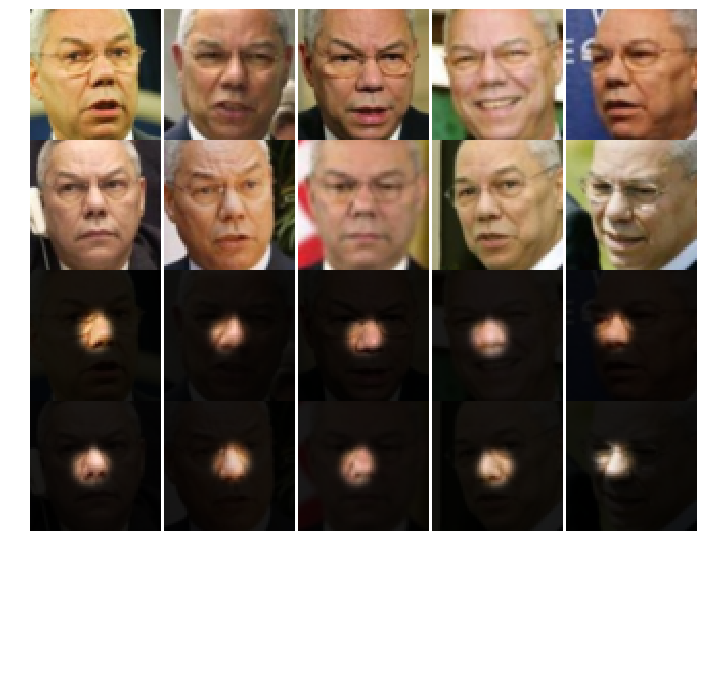

In [33]:
imshow(np.concatenate((im_te[inv1_te_inds],vis_d_ims), axis=0), size=12)

Does this set of neurons light up on other people's nose?
The result directly below shows that it generally does, although not as consistently as with Powell.
The fact that this collection of neurons is highly predictive of Powell suggests that this neuron is influential for him, and not for others.

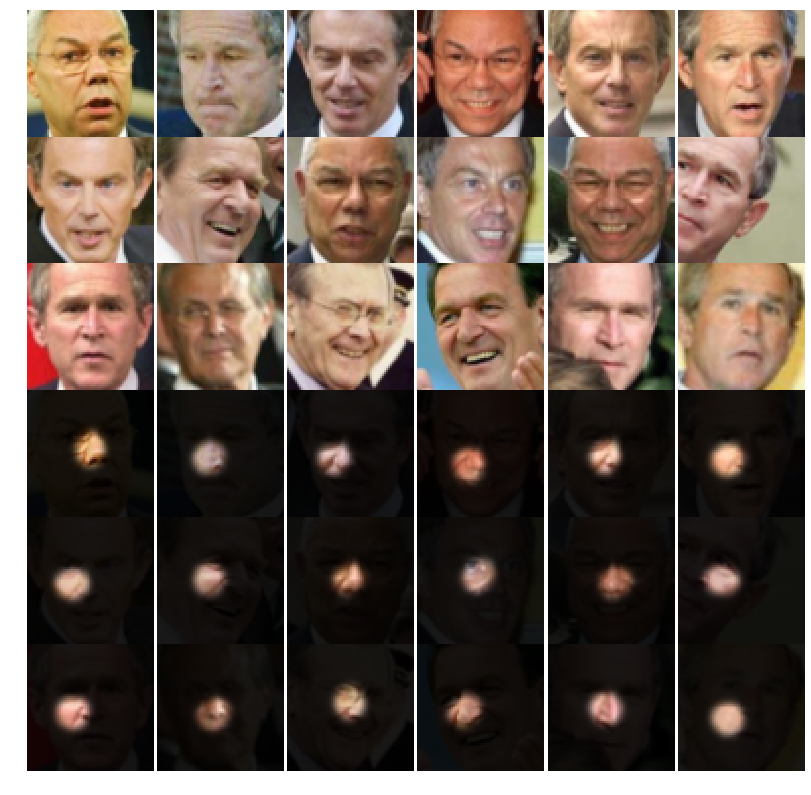

In [34]:
vis_d_ims = vis_d.visualize(im_te[:18])
imshow(np.concatenate((im_te[:18],vis_d_ims), axis=0), size=14)

Before visualizing the part of the invariant from ``flatten_1``, let's follow up on our hypothesis about influence.

We specify a quantity of interest corresponding to the logit for the quantity (class) of invariant 1.
Then we construct an internal attributer for ``dense_1`` using this quantity, and get the attributions for each of the instances that satisfy the invariant.

In [36]:
%%time
from attribution import methods

dense_1 = model.get_layer(name='dense_1')
Q_d1_l0 = model.layers[-1].output[:,maxinvs[1].Q]
infl_d1 = methods.AumannShapley(model, dense_1, Q=Q_d1_l0).compile()
d1_attrs = infl_d1.get_attributions(im_te[inv1_te_inds], resolution=100)

CPU times: user 416 ms, sys: 24 ms, total: 440 ms
Wall time: 408 ms


Now that we have the attributions for these instances towards prediction as Powell, we want to see if the top-attributed neurons intersect with those mentioned in the predicate at this layer.

As the results below show, this is not the case.

In [37]:
flat_order_infl = d1_attrs.argsort(axis=1)[::-1][:,:5]
units = np.array([0,2,9,10])
def intersect(a):
    return len(np.intersect1d(units, a))
np.apply_along_axis(intersect, 1, flat_order_infl)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

We can do the same thing with conductance. 
There is very slightly more intersection, but not much.

In [38]:
%%time
cond_d1 = methods.Conductance(model, dense_1, Q=Q_d1_l0).compile()
d1_conds = cond_d1.get_attributions(im_te[inv1_te_inds])

CPU times: user 1.18 s, sys: 8 ms, total: 1.19 s
Wall time: 1.2 s


In [39]:
flat_order_cond = d1_conds.argsort(axis=1)[::-1][:,:5]
units = np.array([0,2,9,10])
def intersect(a):
    return len(np.intersect1d(units, a))
np.apply_along_axis(intersect, 1, flat_order_cond)

array([1, 0, 0, 0, 0, 0, 0, 1, 1, 1])

Overall, there is more agreement between influence and conductance than either with invariants.

In [40]:
[len(np.intersect1d(flat_order_infl[a], flat_order_cond[a])) for a in range(10)]

[1, 2, 2, 1, 2, 1, 1, 1, 1, 1]

And now we visualize the unit identified at ``flatten_1``

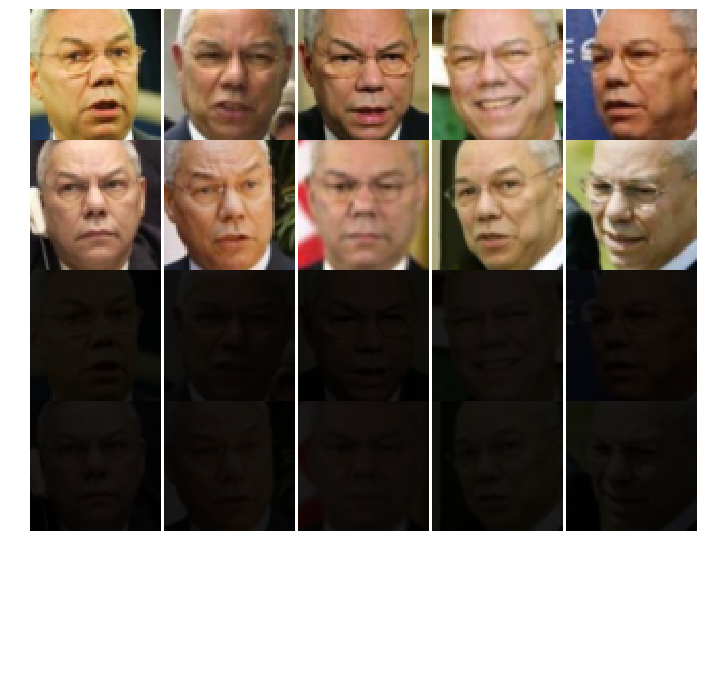

In [41]:
imshow(np.concatenate((im_te[inv1_te_inds], vis_f_ims), axis=0), size=12)

Strange, it looks like there aren't any pixels in these images that are influential on the flat unit identified in the invariant.
This could have to do with the fact that the unit is constrained to 0 in the invariant, so it is always turned off in the relevant images.

Let's see if it shows up in some other random images.

In [42]:
vis_f_ims = vis_f.visualize(im_te[:18])

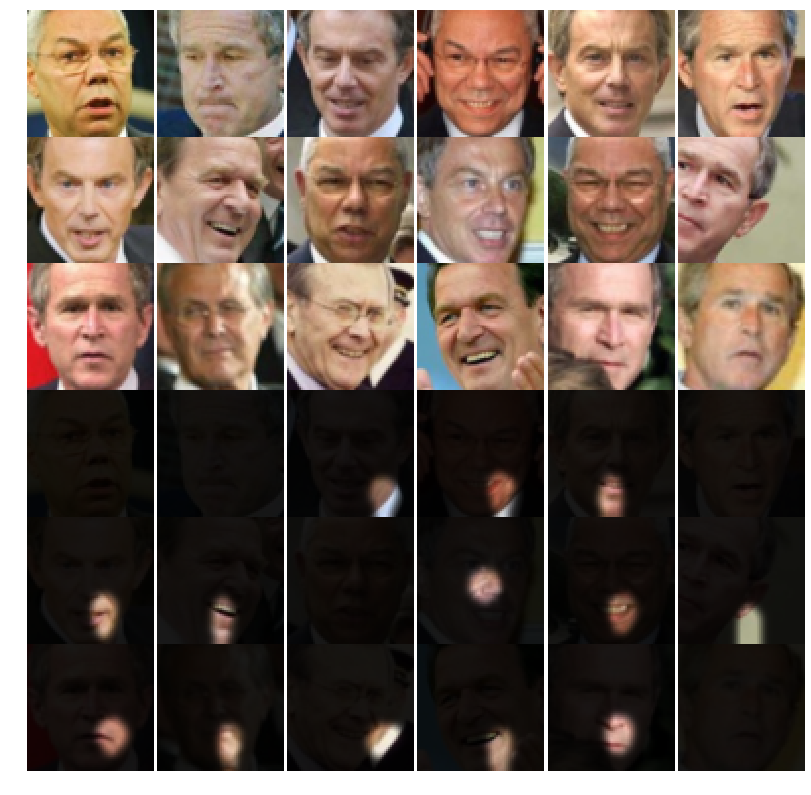

In [43]:
imshow(np.concatenate((im_te[:18], vis_f_ims), axis=0), size=14)

Hard to tell what this neuron represents, but there is some consistency with activating on nose+mouth or on a collared shirt.